In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGHKL_HUMAN"
myfiles = [x for x in os.listdir(".") if "airr" in x]
myfiles

['sc5p_v2_hs_B_1k_multi_5gex_b_vdj_b_airr_rearrangement.tsv']

In [3]:
run = "runTenX-freq"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: runTenX-freq-similarity-IGHKL_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

cell_id  clone_id                  sequence_id  \
0  AAACCTGAGGGCTCTC-1       NaN  AAACCTGAGGGCTCTC-1_contig_1   
1  AAACCTGAGGGCTCTC-1       NaN  AAACCTGAGGGCTCTC-1_contig_2   
2  AAACCTGGTAAGGATT-1       NaN  AAACCTGGTAAGGATT-1_contig_1   
3  AAACCTGGTAAGGATT-1       NaN  AAACCTGGTAAGGATT-1_contig_2   
4  AAACCTGGTAATAGCA-1       NaN  AAACCTGGTAATAGCA-1_contig_1   

                                            sequence  \
0  ACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACATCT...   
1  GCTCTGCTTCAGCTGTGGGCACAAGAGGCAGCACTCAGGACAATCT...   
2  GAGCTACAACAGGCAGGCAGGGGCAGCAAGATGGTGTTGCAGACCC...   
3  GGGAGCATCACCCAGCAACCACATCTGTCCTCTAGAGAATCCCCTG...   
4  ACCCAAAAACCACACCCCTCCTTGGGAGAATCCCCTAGATCACAGC...   

                                         sequence_aa productive rev_comp  \
0  MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSQTLSLTCTVSGG...          T        F   
1  MAWSPLLLTLLAHCTGSWAQSVLTQPPSVSGAPGQRVTISCTGSSS...          T        F   
2  MVLQTQVFISLLLWISGASGDIVMTQSPDSLAVSLGERATVNCKSS...          T        F   
3  MDWTWRILFLVAAATGGHSQVQLVQSGAEVKKPGASVKVSCKASGY...          T        F   
4  MDWTWSILFLVAAATGAHSQVQLVQSGAEVKKPGASVKVSCKASGY...          T        F   

     v_call      v_cigar    d_call   ...    v_sequence_end d_sequence_start  \
0  IGHV4-61  35S356M145S       NaN   ...               391              NaN   
1  IGLV1-40  51S356M243S       NaN   ...               407              NaN   
2   IGKV4-1  30S363M173S       NaN   ...               393              NaN   
3   IGHV1-2  64S353M148S       NaN   ...               417              NaN   
4  IGHV1-18  54S353M142S  IGHD6-13   ...               407            418.0   

  d_sequence_end j_sequence_start j_sequence_end c_sequence_start  \
0            NaN              415            465            466.0   
1            NaN              402            439            440.0   
2            NaN              392            430            431.0   
3            NaN              444            494            495.0   
4          438.0              428            478            479.0   

  c_sequence_end consensus_count duplicate_count  is_cell  
0          536.0             889              14        T  
1          650.0            5214              60        T  
2          566.0            2099              28        T  
3          565.0            1410              20        T  
4          549.0            3982              60        T  

[5 rows x 32 columns]

In [6]:
clones["Sample"] = clones["cell_id"] # Consider each cell as a different sample
clones["cdr3pep"] = clones["junction_aa"] # The CDR3 peptide sequence
clones["freq"] = clones["consensus_count"] # use the frequency

In [7]:
clones.columns

Index(['cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa',
       'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar',
       'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment',
       'germline_alignment', 'junction', 'junction_aa', 'junction_length',
       'junction_aa_length', 'v_sequence_start', 'v_sequence_end',
       'd_sequence_start', 'd_sequence_end', 'j_sequence_start',
       'j_sequence_end', 'c_sequence_start', 'c_sequence_end',
       'consensus_count', 'duplicate_count', 'is_cell', 'Sample', 'cdr3pep',
       'freq'],
      dtype='object')

In [8]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

Sample               cdr3pep  clone_id  junction_length  \
2236  TTTGTCAAGTGTTTGC-1          CQQSYSTPPNTF       0.0               36   
2235  TTTGTCAAGTGTTTGC-1  CARKNYYDSSGYYPDAFDIW       0.0               60   
2234  TTTGGTTCATTAGGCT-1         CAVWDDSLSGRVF       0.0               39   
2233  TTTGGTTCATTAGGCT-1          CARDEVAGREFW       0.0               36   
2232  TTTGGTTCATCTCGCT-1          CLLYYGGADYVF       0.0               36   

      junction_aa_length  v_sequence_start  v_sequence_end  d_sequence_start  \
2236                  12                29             381               0.0   
2235                  20                63             415             416.0   
2234                  13                47             397               0.0   
2233                  12                80             432               0.0   
2232                  12                35             385               0.0   

      d_sequence_end  j_sequence_start  j_sequence_end  c_sequence_start  \
2236             0.0               381             419             420.0   
2235           446.0               446             495             496.0   
2234             0.0               397             434             435.0   
2233             0.0               443             488             489.0   
2232             0.0               385             422             423.0   

      c_sequence_end  consensus_count  duplicate_count  freq  
2236           555.0             2655               36  2655  
2235           566.0             1291               24  1291  
2234           645.0             2142               34  2142  
2233           670.0              191               10   191  
2232           633.0             3530               43  3530

In [9]:
clones["Patient"] = clones["Sample"] # Consider each cell as a different patient

In [10]:
df = clones.copy()

## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient             AAACCTGAGGGCTCTC-1 AAACCTGGTAAGGATT-1 AAACCTGGTAATAGCA-1  \
Sample              AAACCTGAGGGCTCTC-1 AAACCTGGTAAGGATT-1 AAACCTGGTAATAGCA-1   
cdr3pep                                                                        
CAAAGSGWYASWFDPW                   0.0                0.0                0.0   
CAADSRYHSWYFDLW                    0.0                0.0                0.0   
CAADTDKYYYYYGMDVW                  0.0                0.0                0.0   
CAADYGDYSPYYYYGMDVW                0.0                0.0                0.0   
CAAELSAFDIW                        0.0                0.0                0.0   

Patient             AAACCTGGTACGCACC-1 AAACCTGTCCAACCAA-1 AAACCTGTCTATGTGG-1  \
Sample              AAACCTGGTACGCACC-1 AAACCTGTCCAACCAA-1 AAACCTGTCTATGTGG-1   
cdr3pep                                                                        
CAAAGSGWYASWFDPW                   0.0                0.0                0.0   
CAADSRYHSWYFDLW                    0.0                0.0                0.0   
CAADTDKYYYYYGMDVW                  0.0                0.0                0.0   
CAADYGDYSPYYYYGMDVW                0.0                0.0                0.0   
CAAELSAFDIW                        0.0                0.0                0.0   

Patient             AAACGGGCACACAGAG-1 AAACGGGTCCAGTAGT-1 AAACGGGTCGCAGGCT-1  \
Sample              AAACGGGCACACAGAG-1 AAACGGGTCCAGTAGT-1 AAACGGGTCGCAGGCT-1   
cdr3pep                                                                        
CAAAGSGWYASWFDPW                   0.0                0.0                0.0   
CAADSRYHSWYFDLW                    0.0                0.0                0.0   
CAADTDKYYYYYGMDVW                  0.0                0.0                0.0   
CAADYGDYSPYYYYGMDVW                0.0                0.0                0.0   
CAAELSAFDIW                        0.0                0.0                0.0   

Patient             AAAGATGAGATCTGCT-1        ...         TTGGCAACACATTTCT-1  \
Sample              AAAGATGAGATCTGCT-1        ...         TTGGCAACACATTTCT-1   
cdr3pep                                       ...                              
CAAAGSGWYASWFDPW                   0.0        ...                        0.0   
CAADSRYHSWYFDLW                    0.0        ...                        0.0   
CAADTDKYYYYYGMDVW                  0.0        ...                        0.0   
CAADYGDYSPYYYYGMDVW                0.0        ...                        0.0   
CAAELSAFDIW                        0.0        ...                        0.0   

Patient             TTGTAGGCAGGACCCT-1 TTTATGCAGCCAGGAT-1 TTTATGCCAAGACACG-1  \
Sample              TTGTAGGCAGGACCCT-1 TTTATGCAGCCAGGAT-1 TTTATGCCAAGACACG-1   
cdr3pep                                                                        
CAAAGSGWYASWFDPW                   0.0                0.0                0.0   
CAADSRYHSWYFDLW                    0.0                0.0                0.0   
CAADTDKYYYYYGMDVW                  0.0                0.0                0.0   
CAADYGDYSPYYYYGMDVW                0.0                0.0                0.0   
CAAELSAFDIW                        0.0                0.0                0.0   

Patient             TTTATGCCAGCTTAAC-1 TTTATGCTCATAAAGG-1 TTTGCGCTCTGAAAGA-1  \
Sample              TTTATGCCAGCTTAAC-1 TTTATGCTCATAAAGG-1 TTTGCGCTCTGAAAGA-1   
cdr3pep                                                                        
CAAAGSGWYASWFDPW                   0.0                0.0                0.0   
CAADSRYHSWYFDLW                    0.0                0.0                0.0   
CAADTDKYYYYYGMDVW                  0.0                0.0                0.0   
CAADYGDYSPYYYYGMDVW                0.0                0.0                0.0   
CAAELSAFDIW                        0.0                0.0                0.0   

Patient             TTTGGTTCATCTCGCT-1 TTTGGTTCATTAGGCT-1 TTTGTCAAGTGTTTGC-1  
Sample              TTTGGTTCATCTCGCT-1 TTTGGTTCATTAGGCT-1 TTTGTCAAGTGTTTGC-

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                               AAACCTGAGGGCTCTC-1 AAACCTGGTAAGGATT-1  \
Sample                                AAACCTGAGGGCTCTC-1 AAACCTGGTAAGGATT-1   
Patient            Sample                                                     
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1                1.0                0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1                0.0                1.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1                0.0                0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1                0.0                0.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1                0.0                0.0   

Patient                               AAACCTGGTAATAGCA-1 AAACCTGGTACGCACC-1  \
Sample                                AAACCTGGTAATAGCA-1 AAACCTGGTACGCACC-1   
Patient            Sample                                                     
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1                0.0                0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1                0.0                0.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1                1.0                0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1                0.0                1.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1                0.0                0.0   

Patient                               AAACCTGTCCAACCAA-1 AAACCTGTCTATGTGG-1  \
Sample                                AAACCTGTCCAACCAA-1 AAACCTGTCTATGTGG-1   
Patient            Sample                                                     
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1                0.0                0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1                0.0                0.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1                0.0                0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1                0.0                0.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1                1.0                0.0   

Patient                               AAACGGGCACACAGAG-1 AAACGGGTCCAGTAGT-1  \
Sample                                AAACGGGCACACAGAG-1 AAACGGGTCCAGTAGT-1   
Patient            Sample                                                     
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1                0.0                0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1                0.0                0.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1                0.0                0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1                0.0                0.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1                0.0                0.0   

Patient                               AAACGGGTCGCAGGCT-1 AAAGATGAGATCTGCT-1  \
Sample                                AAACGGGTCGCAGGCT-1 AAAGATGAGATCTGCT-1   
Patient            Sample                                                     
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1                0.0                0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1                0.0                0.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1                0.0                0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1                0.0                0.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1                0.0                0.0   

Patient                                      ...         TTGGCAACACATTTCT-1  \
Sample                                       ...         TTGGCAACACATTTCT-1   
Patient            Sample                    ...                              
AAACCTGAGGGCTCTC-1 AAACCTGAGGGCTCTC-1        ...                        0.0   
AAACCTGGTAAGGATT-1 AAACCTGGTAAGGATT-1        ...                        0.0   
AAACCTGGTAATAGCA-1 AAACCTGGTAATAGCA-1        ...                        0.0   
AAACCTGGTACGCACC-1 AAACCTGGTACGCACC-1        ...                        0.0   
AAACCTGTCCAACCAA-1 AAACCTGTCCAACCAA-1        ...                        0.0   

Patient                               TTGTAGGCAGGACCCT-1 TTTATGCAGCCAGGAT-1  \
Sample                                TTGTAGGCAGGACCCT-1 TTTATGCAGCCAGGAT-1   
Patient            Sample                   

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote runTenX-freq-similarity-IGHKL_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.008292383292383243
max value: 1.0
Wrote runTenX-freq-similarity-IGHKL_HUMAN.pdf to disk


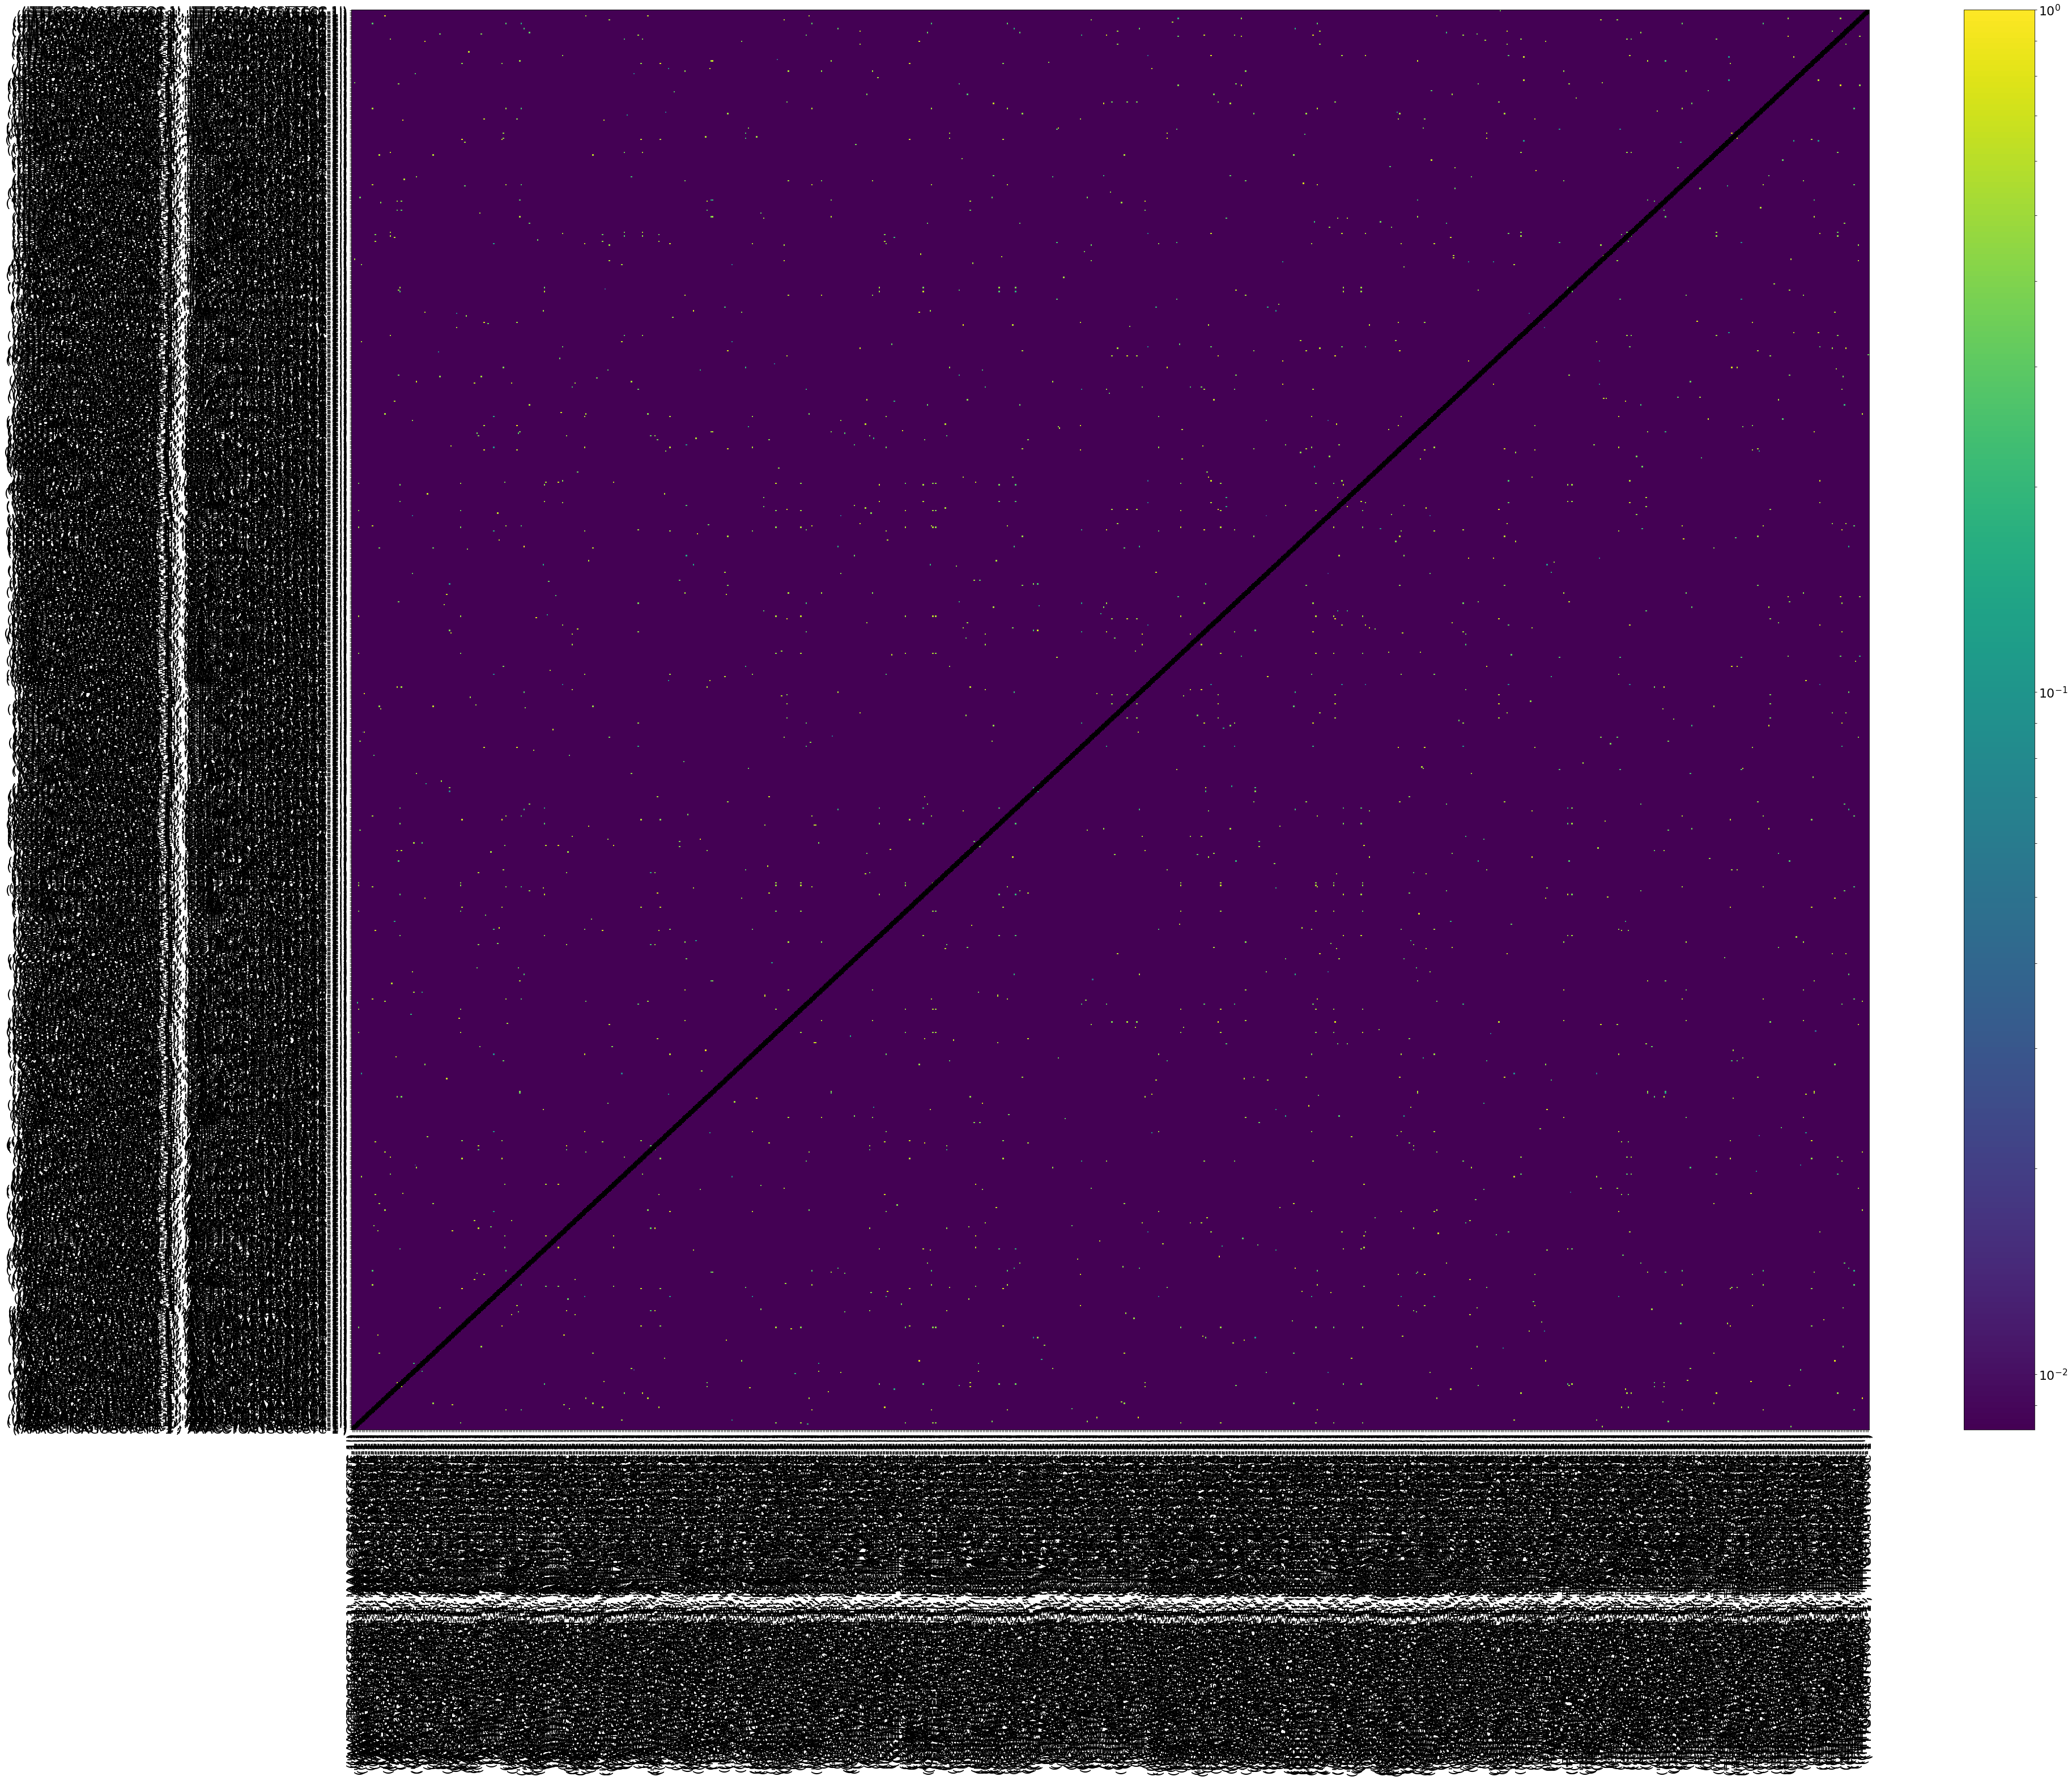

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient nan nan
mean diff patient 0.009056817749630897 0.01957053571830845
threshold 0.0873389606228647


/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/data/home/bioinfo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8ece234fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8ece234be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8ece234128>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8ece268ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8ece2687f0>,
 'means': []}

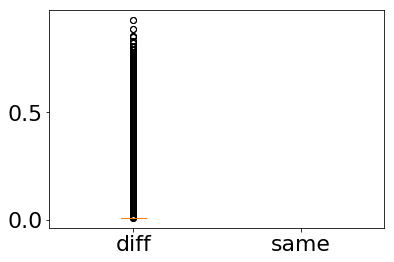

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

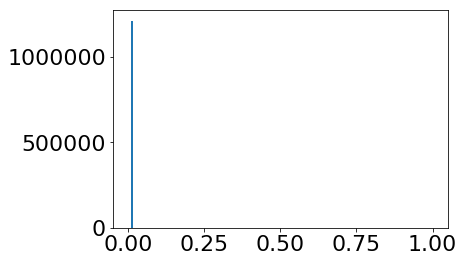

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('AAACCTGGTAATAGCA-1', 'AAACCTGGTAATAGCA-1') ('TATCAGGAGTTTGCGT-1', 'TATCAGGAGTTTGCGT-1') 0.49570019009685884
('AAACCTGGTAATAGCA-1', 'AAACCTGGTAATAGCA-1') ('TGGGCGTTCGCGATCG-1', 'TGGGCGTTCGCGATCG-1') 0.3692719596334054
('AAACCTGTCCAACCAA-1', 'AAACCTGTCCAACCAA-1') ('CATCAGACAGCTGTTA-1', 'CATCAGACAGCTGTTA-1') 0.20110923559199423
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('ACGCCGAAGGATATAC-1', 'ACGCCGAAGGATATAC-1') 0.36693939814172793
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('CAGCGACTCTTAGAGC-1', 'CAGCGACTCTTAGAGC-1') 0.42133757961783436
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('CATATGGAGGGTGTTG-1', 'CATATGGAGGGTGTTG-1') 0.4952274003368894
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('CGAACATAGATCCGAG-1', 'CGAACATAGATCCGAG-1') 0.39210747271200674
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('CGATCGGTCCCAAGTA-1', 'CGATCGGTCCCAAGTA-1') 0.5
('AAACCTGTCTATGTGG-1', 'AAACCTGTCTATGTGG-1') ('CGATGGCCAGTTTACG-1', 'CGATGGCCAGTTTACG-1') 0.4346254927726675
('AAACCTGTCTATGTGG-1', 'AAACC

('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('CCTATTAGTTTGTTGG-1', 'CCTATTAGTTTGTTGG-1') 0.3629179331306991
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('CGACTTCTCTTGTTTG-1', 'CGACTTCTCTTGTTTG-1') 0.2677130044843049
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('CGGCTAGAGAGAACAG-1', 'CGGCTAGAGAGAACAG-1') 0.349685166202958
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') 0.34092758340113916
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('GGAACTTCACACCGCA-1', 'GGAACTTCACACCGCA-1') 0.34663957032951076
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') 0.3527847540257054
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('TACGGATAGACCTAGG-1', 'TACGGATAGACCTAGG-1') 0.24472227915556466
('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') ('TACGGGCAGGAGCGTT-1', 'TACGGGCAGGAGCGTT-1') 0.5137693631669535
('AATCCAGGTTGTGGAG-1', 'AATCCAGGTTGTGGAG-1') ('AAGGTTCTCTGTGCAA-1', 'AAGGTTCTCTGTGCAA-1') 0.6488820354664611
('AATCCAGGTTGTGGA

('ACGCCGACAGTACACT-1', 'ACGCCGACAGTACACT-1') ('TGAGAGGGTCAGAGGT-1', 'TGAGAGGGTCAGAGGT-1') 0.7722571111932028
('ACGCCGACAGTACACT-1', 'ACGCCGACAGTACACT-1') ('TGTGTTTGTTGGAGGT-1', 'TGTGTTTGTTGGAGGT-1') 0.41781030802073804
('ACGGAGAAGGATGTAT-1', 'ACGGAGAAGGATGTAT-1') ('TCGGTAAAGTTGCAGG-1', 'TCGGTAAAGTTGCAGG-1') 0.3166278166278166
('ACGGAGAAGGATGTAT-1', 'ACGGAGAAGGATGTAT-1') ('TGACTTTCACCTATCC-1', 'TGACTTTCACCTATCC-1') 0.5178493114639067
('ACGGAGACAATTGCTG-1', 'ACGGAGACAATTGCTG-1') ('GTTCTCGTCTATCCTA-1', 'GTTCTCGTCTATCCTA-1') 0.4328028807062376
('ACGGAGAGTATGCTTG-1', 'ACGGAGAGTATGCTTG-1') ('GCGAGAAGTGACGCCT-1', 'GCGAGAAGTGACGCCT-1') 0.42035552457302194
('ACGGCCAAGTGCTGCC-1', 'ACGGCCAAGTGCTGCC-1') ('TTAGGCACATTGGTAC-1', 'TTAGGCACATTGGTAC-1') 0.6105263157894737
('ACGGGCTCAATGGATA-1', 'ACGGGCTCAATGGATA-1') ('CTGTTTAGTTACCAGT-1', 'CTGTTTAGTTACCAGT-1') 0.4505211526670754
('ACGGGCTGTTTGGCGC-1', 'ACGGGCTGTTTGGCGC-1') ('AGACGTTGTAGGACAC-1', 'AGACGTTGTAGGACAC-1') 0.6362991846862814
('ACGGGCTGTTTGGCG

('AGACGTTGTAGGACAC-1', 'AGACGTTGTAGGACAC-1') ('ACGGGCTGTTTGGCGC-1', 'ACGGGCTGTTTGGCGC-1') 0.6362991846862814
('AGACGTTGTAGGACAC-1', 'AGACGTTGTAGGACAC-1') ('AGGGAGTAGTGCCATT-1', 'AGGGAGTAGTGCCATT-1') 0.5263010042840087
('AGACGTTGTAGGACAC-1', 'AGACGTTGTAGGACAC-1') ('GTCACAATCCAAACAC-1', 'GTCACAATCCAAACAC-1') 0.6446662693682956
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('ACTGAGTCACGGTTTA-1', 'ACTGAGTCACGGTTTA-1') 0.5515759312320917
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('CTCGAGGTCAGCGATT-1', 'CTCGAGGTCAGCGATT-1') 0.6942594232472183
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('GGGATGAGTGTGACCC-1', 'GGGATGAGTGTGACCC-1') 0.6233610008420546
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('GGTATTGTCAACGCTA-1', 'GGTATTGTCAACGCTA-1') 0.8327992714271258
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('GTTCATTGTCTCTTTA-1', 'GTTCATTGTCTCTTTA-1') 0.472476648227079
('AGAGCTTCACCCATGG-1', 'AGAGCTTCACCCATGG-1') ('TGCCAAAGTAGCTGCC-1', 'TGCCAAAGTAGCTGCC-1') 0.40133715377268386
('AGAGCTTGTCTCTTAT-

('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('ACGGGTCTCAGCTGGC-1', 'ACGGGTCTCAGCTGGC-1') 0.6096659769435413
('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('ATCTGCCGTCAACTGT-1', 'ATCTGCCGTCAACTGT-1') 0.2902747492368076
('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('ATGAGGGCAGCTCGCA-1', 'ATGAGGGCAGCTCGCA-1') 0.7663013189671187
('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('CCTACACAGCAGGTCA-1', 'CCTACACAGCAGGTCA-1') 0.49397767332549947
('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('CGATTGATCACATGCA-1', 'CGATTGATCACATGCA-1') 0.4346909742346804
('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') ('GGGTCTGAGCCGATTT-1', 'GGGTCTGAGCCGATTT-1') 0.4594287875922073
('AGCTTGATCCCGACTT-1', 'AGCTTGATCCCGACTT-1') ('ACTGCTCAGCTGAAAT-1', 'ACTGCTCAGCTGAAAT-1') 0.3236437696722829
('AGCTTGATCCCGACTT-1', 'AGCTTGATCCCGACTT-1') ('CGCTATCGTATATGAG-1', 'CGCTATCGTATATGAG-1') 0.4682823467090451
('AGGCCACCACGGCTAC-1', 'AGGCCACCACGGCTAC-1') ('AAAGTAGCAATAAGCA-1', 'AAAGTAGCAATAAGCA-1') 0.43602391629297454
('AGGCCACCACGGCTA

('ATCATCTAGGATGGAA-1', 'ATCATCTAGGATGGAA-1') ('TCGTACCGTTCCTCCA-1', 'TCGTACCGTTCCTCCA-1') 0.2356717102246676
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('CATCAGACAGCTCCGA-1', 'CATCAGACAGCTCCGA-1') 0.2892483349191246
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('CTCGGAGAGACAATAC-1', 'CTCGGAGAGACAATAC-1') 0.16252917462338212
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('CTCTGGTTCGAGAGCA-1', 'CTCTGGTTCGAGAGCA-1') 0.4658451239920889
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('GAGGTGATCATATCGG-1', 'GAGGTGATCATATCGG-1') 0.4402588066139468
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('GATGCTATCAAACGGG-1', 'GATGCTATCAAACGGG-1') 0.3659177820267686
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('GCGGGTTTCGTCACGG-1', 'GCGGGTTTCGTCACGG-1') 0.48349913153323865
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('GTATCTTGTTGGAGGT-1', 'GTATCTTGTTGGAGGT-1') 0.3171085335542668
('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') ('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') 0.48434039860803546
('ATCATGGTCCACTC

('CAACTAGTCACTCTTA-1', 'CAACTAGTCACTCTTA-1') ('CTCACACTCGTTGCCT-1', 'CTCACACTCGTTGCCT-1') 0.29120853843676675
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('CAGGTGCTCCGTACAA-1', 'CAGGTGCTCCGTACAA-1') 0.5523423944476575
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('CATGACACACTTGGAT-1', 'CATGACACACTTGGAT-1') 0.5903671164104174
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') 0.4156941649899396
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('GCACATAAGACCCACC-1', 'GCACATAAGACCCACC-1') 0.5054035410439182
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('TACCTTAGTCGCTTTC-1', 'TACCTTAGTCGCTTTC-1') 0.6293694597758823
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('TCGGTAATCGAACGGA-1', 'TCGGTAATCGAACGGA-1') 0.36096589494647746
('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') ('TGTCCCAGTTGTCGCG-1', 'TGTCCCAGTTGTCGCG-1') 0.42799486332782977
('CAACTAGTCGGAAACG-1', 'CAACTAGTCGGAAACG-1') ('CCGTGGACAGTAACGG-1', 'CCGTGGACAGTAACGG-1') 0.3772781065088757
('CAACTAGTCGGAAA

('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('ACTTACTAGAAACCTA-1', 'ACTTACTAGAAACCTA-1') 0.08998417363780242
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('AGGTCATGTCGAGATG-1', 'AGGTCATGTCGAGATG-1') 0.6348695712986923
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('ATTGGACTCATTATCC-1', 'ATTGGACTCATTATCC-1') 0.5916133030365627
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('CCTCTGACAAAGCAAT-1', 'CCTCTGACAAAGCAAT-1') 0.3219700450243499
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('GAAGCAGAGAGGGCTT-1', 'GAAGCAGAGAGGGCTT-1') 0.45307978503513846
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('GCGGGTTGTAGAAAGG-1', 'GCGGGTTGTAGAAAGG-1') 0.39329168036829987
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('GGGATGATCCACTGGG-1', 'GGGATGATCCACTGGG-1') 0.5205210447077306
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('GGTGAAGTCGGTGTTA-1', 'GGTGAAGTCGGTGTTA-1') 0.4700128287363695
('CACTCCATCAGGTTCA-1', 'CACTCCATCAGGTTCA-1') ('TCAACGATCCTATTCA-1', 'TCAACGATCCTATTCA-1') 0.5511299221525205
('CAGAGAGGTACCGG

('CATCAGACAGCTCCGA-1', 'CATCAGACAGCTCCGA-1') ('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') 0.3210137275607181
('CATCAGACAGCTGTTA-1', 'CATCAGACAGCTGTTA-1') ('AAACCTGTCCAACCAA-1', 'AAACCTGTCCAACCAA-1') 0.20110923559199423
('CATCAGAGTTTGACTG-1', 'CATCAGAGTTTGACTG-1') ('AACTCCCGTCAGTGGA-1', 'AACTCCCGTCAGTGGA-1') 0.5170525267612647
('CATCAGAGTTTGACTG-1', 'CATCAGAGTTTGACTG-1') ('AGGTCATGTGCGAAAC-1', 'AGGTCATGTGCGAAAC-1') 0.3340967450898744
('CATCAGAGTTTGACTG-1', 'CATCAGAGTTTGACTG-1') ('ATCCGAAGTATAGTAG-1', 'ATCCGAAGTATAGTAG-1') 0.4813783684404055
('CATCAGAGTTTGACTG-1', 'CATCAGAGTTTGACTG-1') ('GGTGTTATCAGGTTCA-1', 'GGTGTTATCAGGTTCA-1') 0.3631648936170213
('CATCAGAGTTTGACTG-1', 'CATCAGAGTTTGACTG-1') ('TTTATGCTCATAAAGG-1', 'TTTATGCTCATAAAGG-1') 0.5495971470083212
('CATCCACAGGGTATCG-1', 'CATCCACAGGGTATCG-1') ('CTCGGGACACGGCGTT-1', 'CTCGGGACACGGCGTT-1') 0.41031247153138384
('CATCCACGTCTTCGTC-1', 'CATCCACGTCTTCGTC-1') ('AAAGCAATCATTGCCC-1', 'AAAGCAATCATTGCCC-1') 0.6259691824516636
('CATCCACGTCTTCGT

('CCTACACAGTTCGATC-1', 'CCTACACAGTTCGATC-1') ('ACTTGTTAGCAGATCG-1', 'ACTTGTTAGCAGATCG-1') 0.38778625954198476
('CCTACACAGTTCGATC-1', 'CCTACACAGTTCGATC-1') ('GCTTCCAGTCTCGTTC-1', 'GCTTCCAGTCTCGTTC-1') 0.40245061793598813
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('CAACTAGTCAGGCCCA-1', 'CAACTAGTCAGGCCCA-1') 0.4156941649899396
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('CAGGTGCTCCGTACAA-1', 'CAGGTGCTCCGTACAA-1') 0.5223767383059419
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('CATGACACACTTGGAT-1', 'CATGACACACTTGGAT-1') 0.4017891870867367
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('GCACATAAGACCCACC-1', 'GCACATAAGACCCACC-1') 0.3904374940943022
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('TACCTTAGTCGCTTTC-1', 'TACCTTAGTCGCTTTC-1') 0.43522224562881817
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('TCGGTAATCGAACGGA-1', 'TCGGTAATCGAACGGA-1') 0.5206463195691202
('CCTACACGTTGGACCC-1', 'CCTACACGTTGGACCC-1') ('TGTCCCAGTTGTCGCG-1', 'TGTCCCAGTTGTCGCG-1') 0.48968949988148847
('CCTACCAAGCTAT

('CGACTTCTCTTGTTTG-1', 'CGACTTCTCTTGTTTG-1') ('TACGGATAGACCTAGG-1', 'TACGGATAGACCTAGG-1') 0.6209929923960043
('CGACTTCTCTTGTTTG-1', 'CGACTTCTCTTGTTTG-1') ('TACGGGCAGGAGCGTT-1', 'TACGGGCAGGAGCGTT-1') 0.3516377649325626
('CGAGAAGCAATGCCAT-1', 'CGAGAAGCAATGCCAT-1') ('ATGCGATTCCGCGTTT-1', 'ATGCGATTCCGCGTTT-1') 0.7412277227722772
('CGAGAAGCAATGCCAT-1', 'CGAGAAGCAATGCCAT-1') ('CAGCATATCGGTCTAA-1', 'CAGCATATCGGTCTAA-1') 0.6198996497207232
('CGAGAAGCAATGCCAT-1', 'CGAGAAGCAATGCCAT-1') ('CGTGAGCAGATCCGAG-1', 'CGTGAGCAGATCCGAG-1') 0.566560785446145
('CGAGAAGCAATGCCAT-1', 'CGAGAAGCAATGCCAT-1') ('GGGCATCCACCACCAG-1', 'GGGCATCCACCACCAG-1') 0.3730208993033566
('CGAGCCACACTTCTGC-1', 'CGAGCCACACTTCTGC-1') ('AGCAGCCAGAGACGAA-1', 'AGCAGCCAGAGACGAA-1') 0.42371002132196167
('CGAGCCACACTTCTGC-1', 'CGAGCCACACTTCTGC-1') ('CGTCAGGGTCCGCTGA-1', 'CGTCAGGGTCCGCTGA-1') 0.4002255699669701
('CGAGCCACACTTCTGC-1', 'CGAGCCACACTTCTGC-1') ('GTACTCCCAAGGGTCA-1', 'GTACTCCCAAGGGTCA-1') 0.30752089136490246
('CGAGCCACACTTCTGC

('CGCTATCGTATATGAG-1', 'CGCTATCGTATATGAG-1') ('ACTGCTCAGCTGAAAT-1', 'ACTGCTCAGCTGAAAT-1') 0.4970145009951663
('CGCTATCGTATATGAG-1', 'CGCTATCGTATATGAG-1') ('AGCTTGATCCCGACTT-1', 'AGCTTGATCCCGACTT-1') 0.4682823467090451
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('AAGGTTCTCTGTGCAA-1', 'AAGGTTCTCTGTGCAA-1') 0.6826236200018554
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('AATCCAGGTTGTGGAG-1', 'AATCCAGGTTGTGGAG-1') 0.5781409601634321
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('CACAAACGTCCGAATT-1', 'CACAAACGTCCGAATT-1') 0.437060287909947
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('CTTGGCTTCAGTTAGC-1', 'CTTGGCTTCAGTTAGC-1') 0.6074596315669775
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('TCATTACGTGTCGCTG-1', 'TCATTACGTGTCGCTG-1') 0.31372062744125484
('CGCTTCAAGTACATGA-1', 'CGCTTCAAGTACATGA-1') ('TCGAGGCCAATGCCAT-1', 'TCGAGGCCAATGCCAT-1') 0.5291411042944785
('CGCTTCATCAGCTGGC-1', 'CGCTTCATCAGCTGGC-1') ('CCTTACGGTGCAACGA-1', 'CCTTACGGTGCAACGA-1') 0.6264303343055867
('CGGACACCACCTTGTC-

('CGTAGGCAGGATTCGG-1', 'CGTAGGCAGGATTCGG-1') ('TTGCCGTCACAGGTTT-1', 'TTGCCGTCACAGGTTT-1') 0.17038117058946056
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') 0.34092758340113916
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('AGCGTATGTCTAGCCG-1', 'AGCGTATGTCTAGCCG-1') 0.17692388894753508
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('CCTATTAGTTTGTTGG-1', 'CCTATTAGTTTGTTGG-1') 0.26893453145057766
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('CGACTTCTCTTGTTTG-1', 'CGACTTCTCTTGTTTG-1') 0.1955202986467569
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('CGGCTAGAGAGAACAG-1', 'CGGCTAGAGAGAACAG-1') 0.2586020675821632
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('GGAACTTCACACCGCA-1', 'GGAACTTCACACCGCA-1') 0.2562299342608164
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') 0.2610185329387946
('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') ('TACGGATAGACCTAGG-1', 'TACGGATAGACCTAGG-1') 0.17810839532412326
('CGTAGGCCACAG

('CTCGTACGTAGCCTAT-1', 'CTCGTACGTAGCCTAT-1') ('TTTATGCAGCCAGGAT-1', 'TTTATGCAGCCAGGAT-1') 0.44635318095792686
('CTCGTCAGTGACGCCT-1', 'CTCGTCAGTGACGCCT-1') ('AAAGATGAGATCTGCT-1', 'AAAGATGAGATCTGCT-1') 0.6021389852029106
('CTCGTCAGTGACGCCT-1', 'CTCGTCAGTGACGCCT-1') ('CTTCTCTCAATGGACG-1', 'CTTCTCTCAATGGACG-1') 0.6098827719246178
('CTCTAATCACCTCGTT-1', 'CTCTAATCACCTCGTT-1') ('AGCTCCTTCGGTGTCG-1', 'AGCTCCTTCGGTGTCG-1') 0.6249300590612372
('CTCTAATGTACCGGCT-1', 'CTCTAATGTACCGGCT-1') ('GATCGTAGTCATCGGC-1', 'GATCGTAGTCATCGGC-1') 0.17506726457399102
('CTCTACGCACGGACAA-1', 'CTCTACGCACGGACAA-1') ('CGGAGTCAGCCACGCT-1', 'CGGAGTCAGCCACGCT-1') 0.441659023744013
('CTCTACGCACGGACAA-1', 'CTCTACGCACGGACAA-1') ('GATGAGGGTTTCGCTC-1', 'GATGAGGGTTTCGCTC-1') 0.376750024138264
('CTCTACGCACGGACAA-1', 'CTCTACGCACGGACAA-1') ('TCGTAGAGTGTCAATC-1', 'TCGTAGAGTGTCAATC-1') 0.2006976120203917
('CTCTACGCACGGACAA-1', 'CTCTACGCACGGACAA-1') ('TGCTACCTCGTTTAGG-1', 'TGCTACCTCGTTTAGG-1') 0.6641323332990856
('CTCTGGTTCGAGAGCA-

('CTTGGCTTCAGTTAGC-1', 'CTTGGCTTCAGTTAGC-1') ('TCATTACGTGTCGCTG-1', 'TCATTACGTGTCGCTG-1') 0.35170640161256694
('CTTGGCTTCAGTTAGC-1', 'CTTGGCTTCAGTTAGC-1') ('TCGAGGCCAATGCCAT-1', 'TCGAGGCCAATGCCAT-1') 0.6806971390989807
('GAACGGAAGCGATATA-1', 'GAACGGAAGCGATATA-1') ('ATTCTACGTGAGGGTT-1', 'ATTCTACGTGAGGGTT-1') 0.11335012594458438
('GAACGGAAGCGATATA-1', 'GAACGGAAGCGATATA-1') ('CACACAACATTCCTCG-1', 'CACACAACATTCCTCG-1') 0.658012744866651
('GAACGGAAGCGATATA-1', 'GAACGGAAGCGATATA-1') ('TGTGGTAAGTGCAAGC-1', 'TGTGGTAAGTGCAAGC-1') 0.6745661113821705
('GAACGGAGTTGAGTTC-1', 'GAACGGAGTTGAGTTC-1') ('CACAGGCGTCCGTCAG-1', 'CACAGGCGTCCGTCAG-1') 0.5825087456271865
('GAACGGAGTTGAGTTC-1', 'GAACGGAGTTGAGTTC-1') ('GCATGATTCCTCTAGC-1', 'GCATGATTCCTCTAGC-1') 0.6756647538996201
('GAACGGAGTTGAGTTC-1', 'GAACGGAGTTGAGTTC-1') ('TAAGAGAGTCAGTGGA-1', 'TAAGAGAGTCAGTGGA-1') 0.19095362880255218
('GAAGCAGAGAGGGCTT-1', 'GAAGCAGAGAGGGCTT-1') ('AGGTCATGTCGAGATG-1', 'AGGTCATGTCGAGATG-1') 0.5030118753944123
('GAAGCAGAGAGGGCT

('GAGTCCGGTTGAGTTC-1', 'GAGTCCGGTTGAGTTC-1') ('GGCCGATGTTAAGACA-1', 'GGCCGATGTTAAGACA-1') 0.3874422899353648
('GAGTCCGTCCAGGGCT-1', 'GAGTCCGTCCAGGGCT-1') ('CGCGTTTTCGGAAACG-1', 'CGCGTTTTCGGAAACG-1') 0.5052882324916628
('GAGTCCGTCCAGGGCT-1', 'GAGTCCGTCCAGGGCT-1') ('CGTAGGCAGCCATCGC-1', 'CGTAGGCAGCCATCGC-1') 0.3718948881133237
('GAGTCCGTCCAGGGCT-1', 'GAGTCCGTCCAGGGCT-1') ('GGCAATTCAGTTTACG-1', 'GGCAATTCAGTTTACG-1') 0.7688233346820171
('GAGTCCGTCCAGGGCT-1', 'GAGTCCGTCCAGGGCT-1') ('GTTACAGCAGTAACGG-1', 'GTTACAGCAGTAACGG-1') 0.5404596763225894
('GATCGATGTATCACCA-1', 'GATCGATGTATCACCA-1') ('AGCTCTCTCGGTTCGG-1', 'AGCTCTCTCGGTTCGG-1') 0.47931949430310594
('GATCGATGTATCACCA-1', 'GATCGATGTATCACCA-1') ('GGAACTTCAATGGTCT-1', 'GGAACTTCAATGGTCT-1') 0.5576771342906739
('GATCGATGTATCACCA-1', 'GATCGATGTATCACCA-1') ('GGATGTTTCGGCATCG-1', 'GGATGTTTCGGCATCG-1') 0.6704617330803289
('GATCGATGTATCACCA-1', 'GATCGATGTATCACCA-1') ('GTGCATAGTGCGAAAC-1', 'GTGCATAGTGCGAAAC-1') 0.30108837614279493
('GATCGATGTATCACC

('GCAGCCAAGCGCCTCA-1', 'GCAGCCAAGCGCCTCA-1') ('TGCCCTAGTCTTGTCC-1', 'TGCCCTAGTCTTGTCC-1') 0.36869502782265307
('GCAGCCAAGCTAAACA-1', 'GCAGCCAAGCTAAACA-1') ('ACGAGGAGTTCACCTC-1', 'ACGAGGAGTTCACCTC-1') 0.11030237189933012
('GCAGCCAAGCTAAACA-1', 'GCAGCCAAGCTAAACA-1') ('CGTGTCTCAGTGAGTG-1', 'CGTGTCTCAGTGAGTG-1') 0.4015312632922161
('GCAGCCAAGCTAAACA-1', 'GCAGCCAAGCTAAACA-1') ('CGTTAGACAGCGTAAG-1', 'CGTTAGACAGCGTAAG-1') 0.2421881211735708
('GCAGCCAAGCTAAACA-1', 'GCAGCCAAGCTAAACA-1') ('GAGTCCGGTCAAAGAT-1', 'GAGTCCGGTCAAAGAT-1') 0.28504585438892005
('GCAGTTAAGATCCGAG-1', 'GCAGTTAAGATCCGAG-1') ('AGCTCCTCAAACGTGG-1', 'AGCTCCTCAAACGTGG-1') 0.33004385964912286
('GCAGTTATCTTTACAC-1', 'GCAGTTATCTTTACAC-1') ('CAACCAACAATGTTGC-1', 'CAACCAACAATGTTGC-1') 0.32275359210808496
('GCAGTTATCTTTACAC-1', 'GCAGTTATCTTTACAC-1') ('CGGACACTCGGTTAAC-1', 'CGGACACTCGGTTAAC-1') 0.5166104466932434
('GCAGTTATCTTTACAC-1', 'GCAGTTATCTTTACAC-1') ('CGGACTGAGCAGGCTA-1', 'CGGACTGAGCAGGCTA-1') 0.27042752339994935
('GCATGATAGTT

('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('CGAACATAGATCCGAG-1', 'CGAACATAGATCCGAG-1') 0.5541382379115989
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('CGATCGGTCCCAAGTA-1', 'CGATCGGTCCCAAGTA-1') 0.5528178243774574
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('CGATGGCCAGTTTACG-1', 'CGATGGCCAGTTTACG-1') 0.44920127795527154
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('GACGCGTTCCAGATCA-1', 'GACGCGTTCCAGATCA-1') 0.6429878048780489
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('GATCGTACAGGTCCAC-1', 'GATCGTACAGGTCCAC-1') 0.586240444753301
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('GCTTGAAAGTATGACA-1', 'GCTTGAAAGTATGACA-1') 0.5981497056349874
('GCTCCTAGTCGCTTCT-1', 'GCTCCTAGTCGCTTCT-1') ('GGATGTTAGGAGTACC-1', 'GGATGTTAGGAGTACC-1') 0.38140880730626636
('GCTCCTATCCAAAGTC-1', 'GCTCCTATCCAAAGTC-1') ('AAAGCAATCATTGCCC-1', 'AAAGCAATCATTGCCC-1') 0.6310477886613238
('GCTCCTATCCAAAGTC-1', 'GCTCCTATCCAAAGTC-1') ('AGAATAGAGCCAGAAC-1', 'AGAATAGAGCCAGAAC-1') 0.5329246588886691
('GCTCCTATCCAAAGTC

('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('AATCCAGCAAAGGCGT-1', 'AATCCAGCAAAGGCGT-1') 0.3527847540257054
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('AGCGTATGTCTAGCCG-1', 'AGCGTATGTCTAGCCG-1') 0.4596503619989405
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('CCTATTAGTTTGTTGG-1', 'CCTATTAGTTTGTTGG-1') 0.6322820037105752
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('CGACTTCTCTTGTTTG-1', 'CGACTTCTCTTGTTTG-1') 0.49937649880095925
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('CGGCTAGAGAGAACAG-1', 'CGGCTAGAGAGAACAG-1') 0.3662107031437485
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('CGTAGGCCACAGCGTC-1', 'CGTAGGCCACAGCGTC-1') 0.2610185329387946
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('GGAACTTCACACCGCA-1', 'GGAACTTCACACCGCA-1') 0.6202049082678103
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('TACGGATAGACCTAGG-1', 'TACGGATAGACCTAGG-1') 0.46222143301074314
('GGATGTTAGATGTAAC-1', 'GGATGTTAGATGTAAC-1') ('TACGGGCAGGAGCGTT-1', 'TACGGGCAGGAGCGTT-1') 0.47456525272224936
('GGATGTTAGGAGTA

('GGGCATCCACCACCAG-1', 'GGGCATCCACCACCAG-1') ('ATGCGATTCCGCGTTT-1', 'ATGCGATTCCGCGTTT-1') 0.3451761775694089
('GGGCATCCACCACCAG-1', 'GGGCATCCACCACCAG-1') ('CAGCATATCGGTCTAA-1', 'CAGCATATCGGTCTAA-1') 0.4065924583656916
('GGGCATCCACCACCAG-1', 'GGGCATCCACCACCAG-1') ('CGAGAAGCAATGCCAT-1', 'CGAGAAGCAATGCCAT-1') 0.3730208993033566
('GGGCATCCACCACCAG-1', 'GGGCATCCACCACCAG-1') ('CGTGAGCAGATCCGAG-1', 'CGTGAGCAGATCCGAG-1') 0.412790188348664
('GGGCATCGTTCACGGC-1', 'GGGCATCGTTCACGGC-1') ('CAAGATCCATTGCGGC-1', 'CAAGATCCATTGCGGC-1') 0.5593662254312074
('GGGCATCGTTCACGGC-1', 'GGGCATCGTTCACGGC-1') ('CCTACCAAGCTATGCT-1', 'CCTACCAAGCTATGCT-1') 0.18654985828394743
('GGGTCTGAGCCGATTT-1', 'GGGTCTGAGCCGATTT-1') ('ACGGGTCTCAGCTGGC-1', 'ACGGGTCTCAGCTGGC-1') 0.3782310806602305
('GGGTCTGAGCCGATTT-1', 'GGGTCTGAGCCGATTT-1') ('AGCTTGATCAGCAACT-1', 'AGCTTGATCAGCAACT-1') 0.4594287875922073
('GGGTCTGAGCCGATTT-1', 'GGGTCTGAGCCGATTT-1') ('ATCTGCCGTCAACTGT-1', 'ATCTGCCGTCAACTGT-1') 0.30880579010856457
('GGGTCTGAGCCGATTT

('GTATCTTGTTGGAGGT-1', 'GTATCTTGTTGGAGGT-1') ('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') 0.464754816112084
('GTCAAGTAGGCAAAGA-1', 'GTCAAGTAGGCAAAGA-1') ('AGGCCGTGTCAGTGGA-1', 'AGGCCGTGTCAGTGGA-1') 0.229677123883673
('GTCAAGTAGGCAAAGA-1', 'GTCAAGTAGGCAAAGA-1') ('CGGACTGGTTAGAACA-1', 'CGGACTGGTTAGAACA-1') 0.21930687657155357
('GTCAAGTAGGCAAAGA-1', 'GTCAAGTAGGCAAAGA-1') ('CTTGGCTAGTTAGGTA-1', 'CTTGGCTAGTTAGGTA-1') 0.3752338196782641
('GTCAAGTAGGCAAAGA-1', 'GTCAAGTAGGCAAAGA-1') ('GACTACACAGACGCTC-1', 'GACTACACAGACGCTC-1') 0.24154124021673695
('GTCAAGTAGGCAAAGA-1', 'GTCAAGTAGGCAAAGA-1') ('GAGCAGAGTGCTAGCC-1', 'GAGCAGAGTGCTAGCC-1') 0.35316901408450707
('GTCAAGTCAGCGTAAG-1', 'GTCAAGTCAGCGTAAG-1') ('GCCTCTACATTGGTAC-1', 'GCCTCTACATTGGTAC-1') 0.7922185430463576
('GTCAAGTCAGCGTAAG-1', 'GTCAAGTCAGCGTAAG-1') ('GTGAAGGCATGGTCAT-1', 'GTGAAGGCATGGTCAT-1') 0.7620647525962125
('GTCAAGTCAGCGTAAG-1', 'GTCAAGTCAGCGTAAG-1') ('TAGTTGGAGTTGAGAT-1', 'TAGTTGGAGTTGAGAT-1') 0.10136073312968619
('GTCACAATCCAAACA

('GTGTTAGGTCGACTAT-1', 'GTGTTAGGTCGACTAT-1') ('TGACTTTTCCAGAAGG-1', 'TGACTTTTCCAGAAGG-1') 0.10694681052432331
('GTGTTAGGTCGACTAT-1', 'GTGTTAGGTCGACTAT-1') ('TGGTTCCAGAGGGCTT-1', 'TGGTTCCAGAGGGCTT-1') 0.6313566778110153
('GTGTTAGGTCGACTAT-1', 'GTGTTAGGTCGACTAT-1') ('TTAGGACAGAAACCTA-1', 'TTAGGACAGAAACCTA-1') 0.6290954151177199
('GTTAAGCTCCAAACAC-1', 'GTTAAGCTCCAAACAC-1') ('ACGCAGCCACACCGAC-1', 'ACGCAGCCACACCGAC-1') 0.539486356340289
('GTTACAGCACGCTTTC-1', 'GTTACAGCACGCTTTC-1') ('CTGTTTAAGTGCGTGA-1', 'CTGTTTAAGTGCGTGA-1') 0.42167769092002405
('GTTACAGCAGTAACGG-1', 'GTTACAGCAGTAACGG-1') ('CGCGTTTTCGGAAACG-1', 'CGCGTTTTCGGAAACG-1') 0.776143432125869
('GTTACAGCAGTAACGG-1', 'GTTACAGCAGTAACGG-1') ('CGTAGGCAGCCATCGC-1', 'CGTAGGCAGCCATCGC-1') 0.5959371658853524
('GTTACAGCAGTAACGG-1', 'GTTACAGCAGTAACGG-1') ('GAGTCCGTCCAGGGCT-1', 'GAGTCCGTCCAGGGCT-1') 0.5404596763225894
('GTTACAGCAGTAACGG-1', 'GTTACAGCAGTAACGG-1') ('GGCAATTCAGTTTACG-1', 'GGCAATTCAGTTTACG-1') 0.60024166750579
('GTTCATTAGTTTCCTT-1'

('TATCAGGAGCTGTCTA-1', 'TATCAGGAGCTGTCTA-1') ('CAGCTGGTCTCGGACG-1', 'CAGCTGGTCTCGGACG-1') 0.641066911933778
('TATCAGGAGCTGTCTA-1', 'TATCAGGAGCTGTCTA-1') ('CTCGTACGTAGCCTAT-1', 'CTCGTACGTAGCCTAT-1') 0.4118200134318335
('TATCAGGAGCTGTCTA-1', 'TATCAGGAGCTGTCTA-1') ('TCAACGAGTGCAACGA-1', 'TCAACGAGTGCAACGA-1') 0.468886646485032
('TATCAGGAGCTGTCTA-1', 'TATCAGGAGCTGTCTA-1') ('TTTATGCAGCCAGGAT-1', 'TTTATGCAGCCAGGAT-1') 0.5617352614015573
('TATCAGGAGTTTGCGT-1', 'TATCAGGAGTTTGCGT-1') ('AAACCTGGTAATAGCA-1', 'AAACCTGGTAATAGCA-1') 0.49570019009685884
('TATCAGGAGTTTGCGT-1', 'TATCAGGAGTTTGCGT-1') ('TGGGCGTTCGCGATCG-1', 'TGGGCGTTCGCGATCG-1') 0.5471467805920049
('TATCTCAAGGATTCGG-1', 'TATCTCAAGGATTCGG-1') ('GTACTTTGTTGTTTGG-1', 'GTACTTTGTTGTTTGG-1') 0.6524923222300969
('TATCTCAAGGATTCGG-1', 'TATCTCAAGGATTCGG-1') ('TATGCCCAGCTGCGAA-1', 'TATGCCCAGCTGCGAA-1') 0.5645741703318672
('TATCTCATCTGAAAGA-1', 'TATCTCATCTGAAAGA-1') ('CGGTTAAAGGGATCTG-1', 'CGGTTAAAGGGATCTG-1') 0.5742161316749832
('TATGCCCAGCTGCGAA-1

('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('AGAGCTTGTTCTGAAC-1', 'AGAGCTTGTTCTGAAC-1') 0.5309090909090909
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('CACACAAGTGGTGTAG-1', 'CACACAAGTGGTGTAG-1') 0.3843963296117163
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('CACACCTAGCGAGAAA-1', 'CACACCTAGCGAGAAA-1') 0.5274779803994541
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('CCAATCCAGCTACCTA-1', 'CCAATCCAGCTACCTA-1') 0.5512901195720579
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('GGGTTGCAGCGATAGC-1', 'GGGTTGCAGCGATAGC-1') 0.4812949233120154
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('TCGAGGCCATATGCTG-1', 'TCGAGGCCATATGCTG-1') 0.29680114323403317
('TCAGGTAGTAGCACGA-1', 'TCAGGTAGTAGCACGA-1') ('TGTTCCGTCAGTGCAT-1', 'TGTTCCGTCAGTGCAT-1') 0.5651249335459863
('TCATTACAGTTGCAGG-1', 'TCATTACAGTTGCAGG-1') ('ACTATCTAGTTAAGTG-1', 'ACTATCTAGTTAAGTG-1') 0.5015955560808415
('TCATTACAGTTGCAGG-1', 'TCATTACAGTTGCAGG-1') ('CAGAGAGTCAACGGCC-1', 'CAGAGAGTCAACGGCC-1') 0.3046880608801781
('TCATTACGTGTCGCTG

('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('AAGGAGCAGATCCCAT-1', 'AAGGAGCAGATCCCAT-1') 0.6600833881939873
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('ATCACGAAGACTAGGC-1', 'ATCACGAAGACTAGGC-1') 0.34708359776149544
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('ATCATGGTCGAATCCA-1', 'ATCATGGTCGAATCCA-1') 0.5509662056964924
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('GTGGGTCAGGAACTGC-1', 'GTGGGTCAGGAACTGC-1') 0.48841718542708434
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('TCACGAAAGATCTGAA-1', 'TCACGAAAGATCTGAA-1') 0.4532029950083195
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('TCACGAATCTCATTCA-1', 'TCACGAATCTCATTCA-1') 0.4751599399731459
('TGAAAGAAGGCCATAG-1', 'TGAAAGAAGGCCATAG-1') ('TTCGGTCAGCTACCTA-1', 'TTCGGTCAGCTACCTA-1') 0.40254321478243593
('TGACTAGTCCGCATCT-1', 'TGACTAGTCCGCATCT-1') ('CCGTGGACATTAGGCT-1', 'CCGTGGACATTAGGCT-1') 0.374565236778739
('TGACTTTCACCTATCC-1', 'TGACTTTCACCTATCC-1') ('ACGGAGAAGGATGTAT-1', 'ACGGAGAAGGATGTAT-1') 0.5178493114639067
('TGACTTTCACCTATC

('TGCTGCTTCTCCTATA-1', 'TGCTGCTTCTCCTATA-1') ('TACGGTAGTTCCATGA-1', 'TACGGTAGTTCCATGA-1') 0.4829941142112594
('TGGACGCAGCTGATAA-1', 'TGGACGCAGCTGATAA-1') ('CCTAAAGTCTAACTGG-1', 'CCTAAAGTCTAACTGG-1') 0.3729828214471629
('TGGACGCAGCTGATAA-1', 'TGGACGCAGCTGATAA-1') ('CGCTATCCATATACGC-1', 'CGCTATCCATATACGC-1') 0.2612698846802498
('TGGACGCAGCTGATAA-1', 'TGGACGCAGCTGATAA-1') ('GATCGATGTTGGTGGA-1', 'GATCGATGTTGGTGGA-1') 0.3855518934553037
('TGGACGCAGCTGATAA-1', 'TGGACGCAGCTGATAA-1') ('GTACTTTCATATACGC-1', 'GTACTTTCATATACGC-1') 0.5041780279707978
('TGGACGCGTCAACTGT-1', 'TGGACGCGTCAACTGT-1') ('ATTTCTGAGGGCTTGA-1', 'ATTTCTGAGGGCTTGA-1') 0.28031991608758355
('TGGCCAGTCCGCATCT-1', 'TGGCCAGTCCGCATCT-1') ('GGTGAAGCATTAGGCT-1', 'GGTGAAGCATTAGGCT-1') 0.26089504138284625
('TGGCCAGTCCGCATCT-1', 'TGGCCAGTCCGCATCT-1') ('TCTTCGGAGCCAACAG-1', 'TCTTCGGAGCCAACAG-1') 0.30209481808158767
('TGGCTGGTCAACCAAC-1', 'TGGCTGGTCAACCAAC-1') ('GACGCGTCATCTCGCT-1', 'GACGCGTCATCTCGCT-1') 0.41428571428571426
('TGGCTGGTCAACC

('TTCTCCTGTATTCGTG-1', 'TTCTCCTGTATTCGTG-1') ('GACGCGTCATCTCGCT-1', 'GACGCGTCATCTCGCT-1') 0.309483385884065
('TTCTCCTGTATTCGTG-1', 'TTCTCCTGTATTCGTG-1') ('GCAAACTTCACAAACC-1', 'GCAAACTTCACAAACC-1') 0.6236136459357012
('TTCTCCTGTATTCGTG-1', 'TTCTCCTGTATTCGTG-1') ('TGGCTGGTCAACCAAC-1', 'TGGCTGGTCAACCAAC-1') 0.7738998482549317
('TTCTCCTGTATTCGTG-1', 'TTCTCCTGTATTCGTG-1') ('TTTATGCCAAGACACG-1', 'TTTATGCCAAGACACG-1') 0.5004506534474988
('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') ('ATCATGGGTCCATGAT-1', 'ATCATGGGTCCATGAT-1') 0.48434039860803546
('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') ('CATCAGACAGCTCCGA-1', 'CATCAGACAGCTCCGA-1') 0.3210137275607181
('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') ('CTCGGAGAGACAATAC-1', 'CTCGGAGAGACAATAC-1') 0.1826854280944431
('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') ('CTCTGGTTCGAGAGCA-1', 'CTCTGGTTCGAGAGCA-1') 0.7014703452833306
('TTCTCCTTCCTCCTAG-1', 'TTCTCCTTCCTCCTAG-1') ('GAGGTGATCATATCGG-1', 'GAGGTGATCATATCGG-1') 0.6598290598290598
('TTCTCCTTCCTCCTAG-

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.008292383292383243
max value: 1.0
Wrote runTenX-freq-similarity-IGHKL_HUMAN-highlighted.pdf to disk


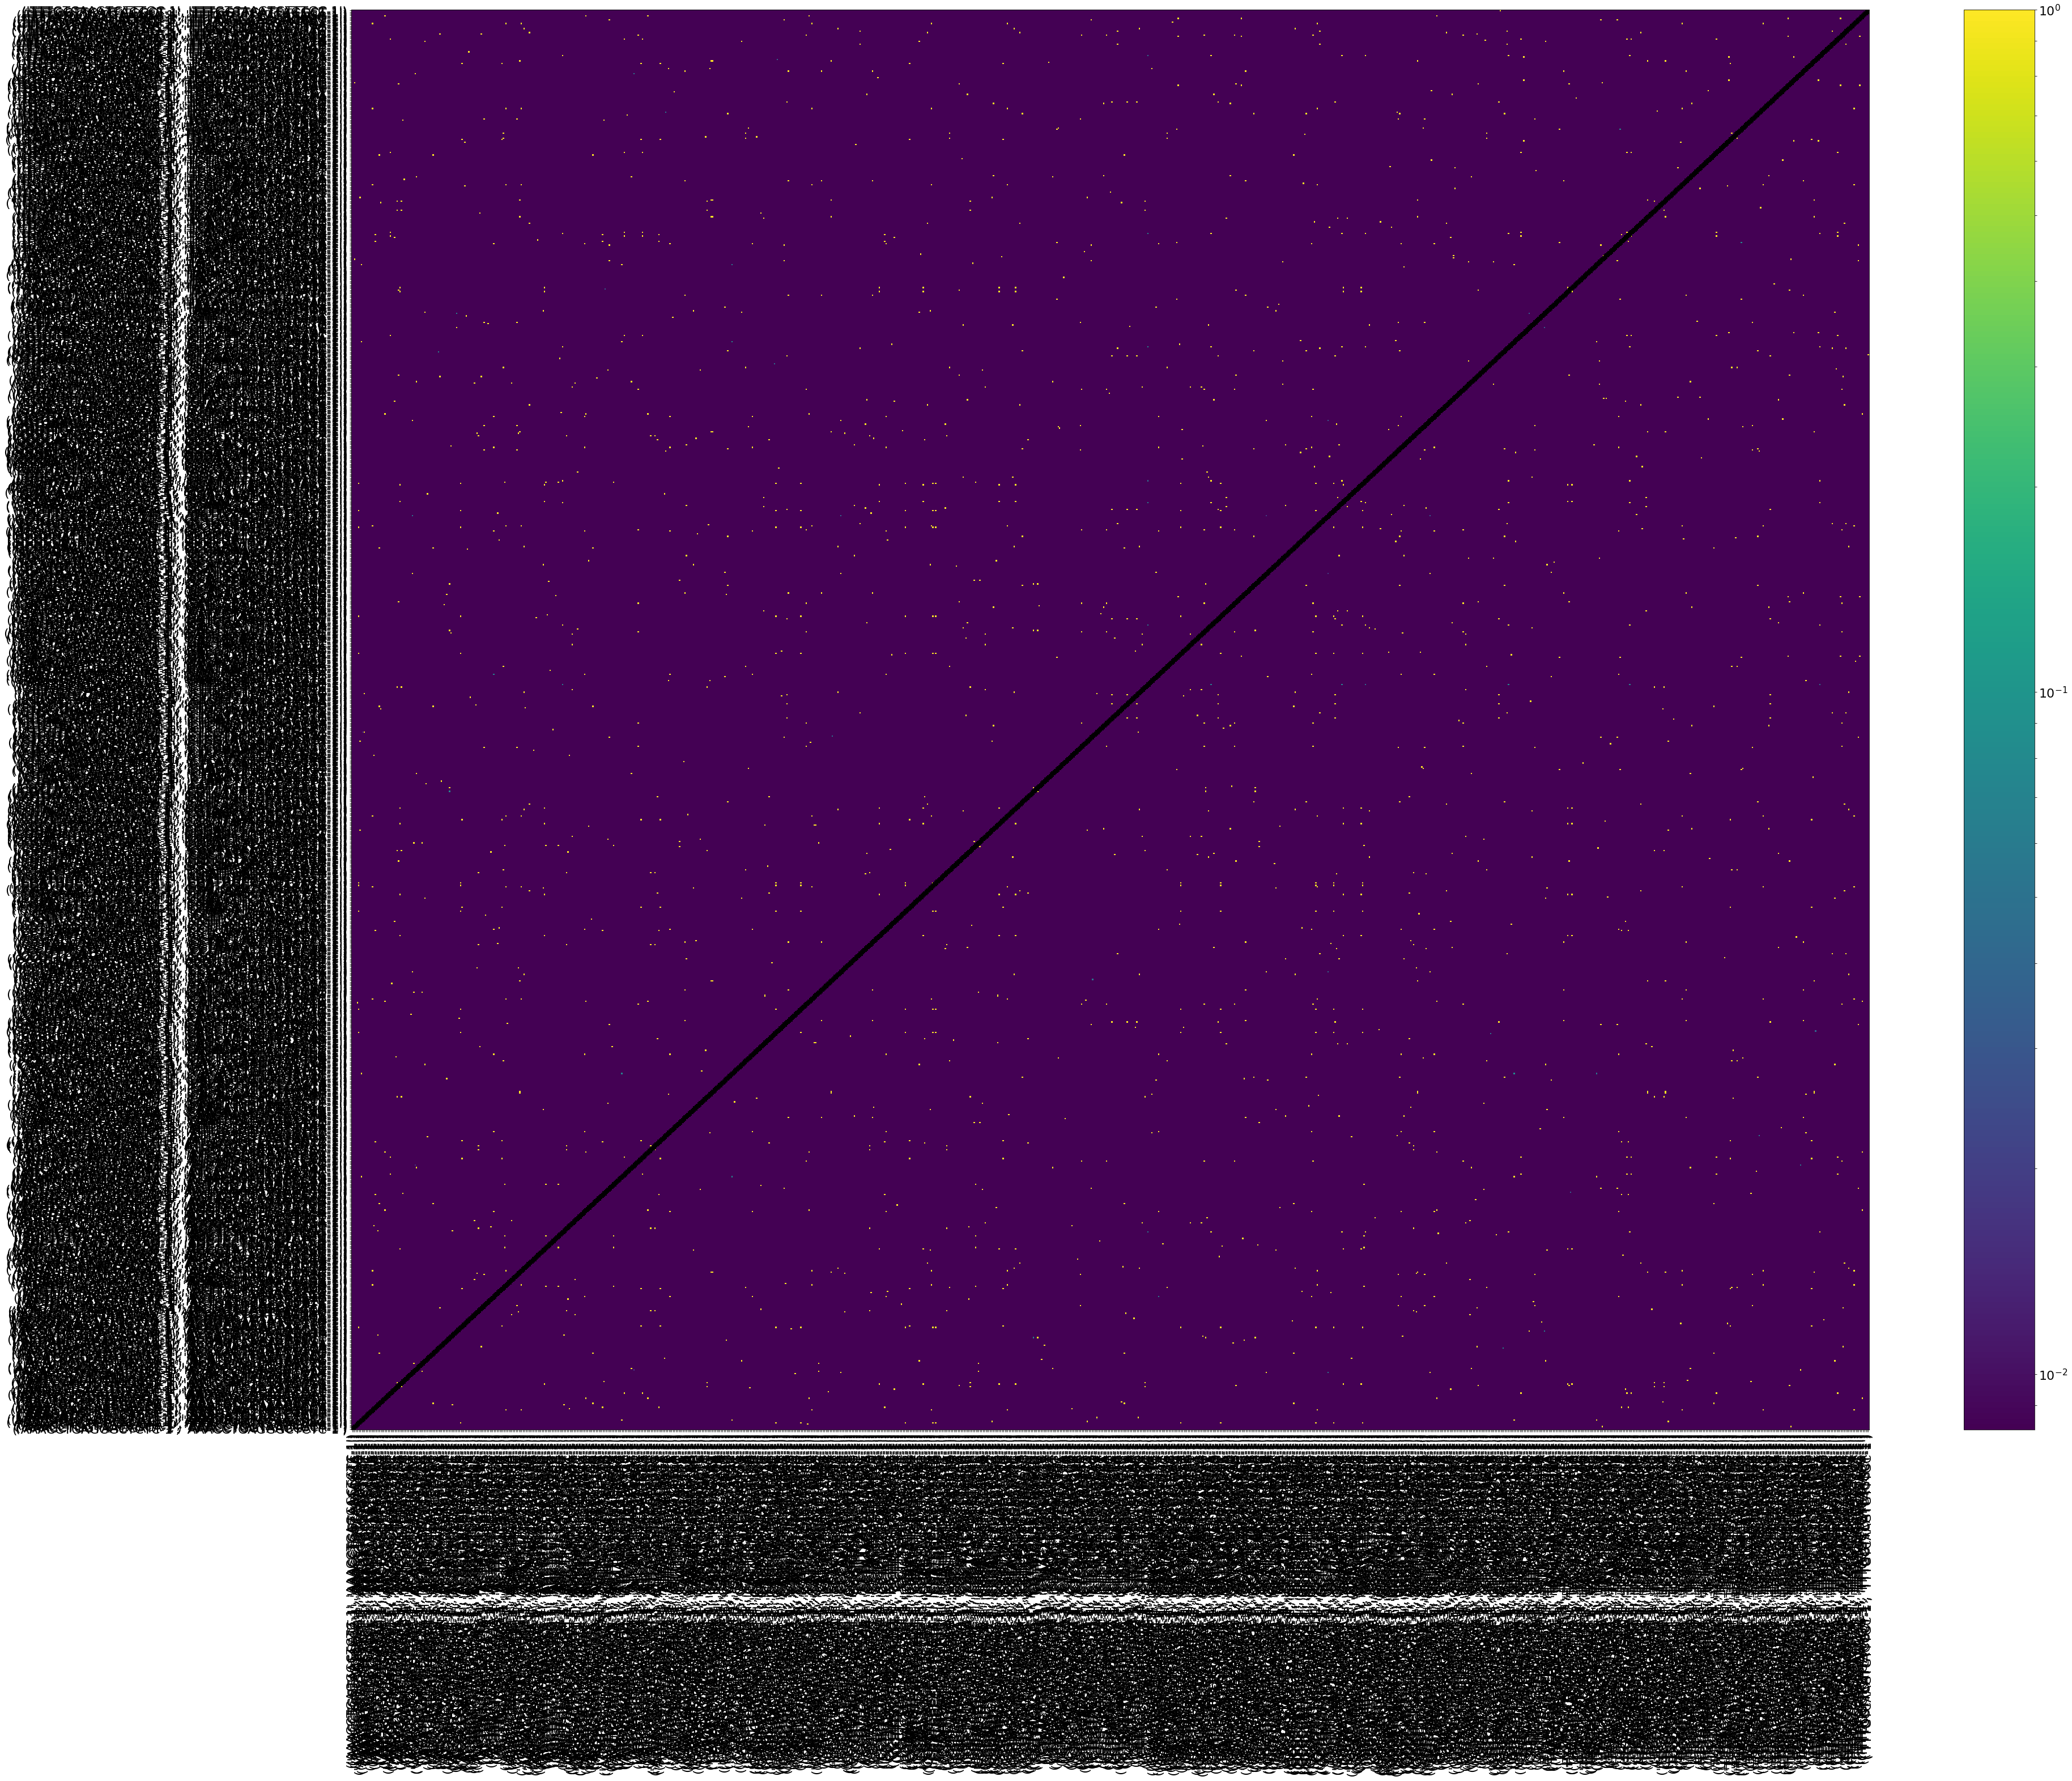

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)